## Name: Pete Gentile
## Email: gentilepetera@gmail.com

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

In [2]:
#This will be used later to generate a confusion matrix.
#Sure, you could use sklearn's pre-written confusion matrix function, but where's the fun in that?
def get_confusion_matrix(df):
    #First, get the predicted/actual labels from the dataframe
    predicted_labels = df["predicted_gender"].values
    labels = df["gender"].values
    
    #Then make the components of the confusion matrix
    true_positives = sum( labels[predicted_labels == 1] )
    false_positives = sum(labels[predicted_labels == 1] == 0)
    true_negatives = sum( labels[predicted_labels == 0] == 0)
    false_negatives = sum( labels[predicted_labels == 0] )
    
    #And return them
    return [[true_positives, false_negatives], [false_positives, true_negatives]]

### Task A
Assemble a dataframe with one row per customer and the following columns:
- customer_id
- gender
- most_recent_order_date
- order_count (number of orders placed by this customer)

Sort the dataframe by customer_id ascending and display the first 10 rows.

In [3]:
#Read in the data
df = pd.read_csv("screening_exercise_orders_v201810.csv")

#Convert times to DateTimes
df["date"] = pd.to_datetime(df["date"])

#Now group the customers by their customer_ids and aggregate by most recent date (i.e. max date),
#total number of orders (i.e. count), and gender (since we're assuming we've recorded the gender
#correctly each time, you can use lots of things, but we'll use max here).
customers = df.groupby("customer_id").agg({"date":"max", "value":"count", "gender":"max"})

#Rename and re-order columns to match those specified by the directions
customers = customers.rename(columns = {"date":"most_recent_order_date", "value":"order_count"})
customers = customers[["gender", "most_recent_order_date", "order_count"]]

#Now print the top 10 rows (they're already in ascending order).
customers.head(10)

,gender,most_recent_order_date,order_count
customer_id,,,
1000,0,2017-01-01 00:11:31,1
1001,0,2017-01-01 00:29:56,1
1002,1,2017-02-19 21:35:31,3
1003,1,2017-04-26 02:37:20,4
1004,0,2017-01-01 03:11:54,1
1005,1,2017-12-16 01:39:27,2
1006,1,2017-05-09 15:27:20,3
1007,0,2017-01-01 15:59:50,1
1008,0,2017-12-17 05:47:48,3


### Task B
Plot the count of orders per week for the store.

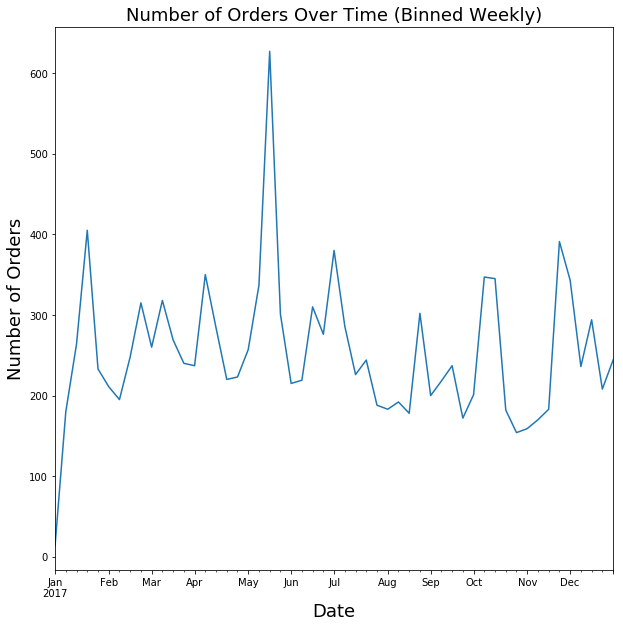

In [4]:
#First, re-order the dataframe by date.
df.index = df["date"]

#Now re-sample the dataframe with a weekly cadence.
orders_per_week = df.resample("W").count()["value"]

#And plot.
plt.figure(figsize=[10,10])
orders_per_week.plot()
plt.title("Number of Orders Over Time (Binned Weekly)", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Number of Orders", fontsize=18)
plt.show()

### Task C
Compute the mean order value for gender 0 and for gender 1. Do you think the difference is significant?

In [5]:
#First, let's separate the orders by gender. We'll call gender = 0 customers "male" and
#gender = 1 customers "female".
male_order_values = df[df["gender"] == 0]["value"]
female_order_values = df[df["gender"] == 1]["value"]

#Now print the mean for each.
print("The mean value for male orders is    %0.1f" % (male_order_values.mean()))
print("The mean value for female orders is  %0.1f" % (female_order_values.mean()))

The mean value for male orders is    363.9
The mean value for female orders is  350.7


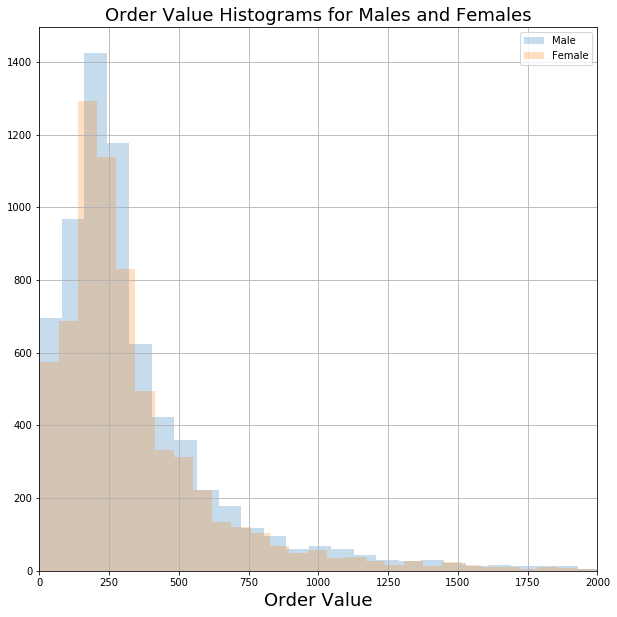

In [6]:
#Is this difference significant? At this point, I'm tempted to use a t-test, but that assumes
#the distribution of order values is normal for both males an females. Let's see if that's true.

plt.figure(figsize=[10,10])
male_order_values.hist(bins=100, alpha = 0.25, label = "Male")
female_order_values.hist(bins=100, alpha = 0.25, label = "Female")
plt.xlim(0,2000)
plt.title("Order Value Histograms for Males and Females", fontsize=18)
plt.xlabel("Order Value", fontsize=18)
plt.legend()
plt.show()


In [7]:
#Since those distributions are significantly non-normal, we'd better use a KS test instead.
p_val = ks_2samp(male_order_values, female_order_values).pvalue
print("Null hypothesis can be rejected with %d percent confidence." % int((100*p_val)))

Null hypothesis can be rejected with 15 percent confidence.


In [8]:
#Adopting the typical 95% confidence rule for rejecting the Null hypothesis, the Null hypothesis
#cannot be rejected, therefore, I do not conclude that the difference in the distributions of male
#and female order values is statistically significant.

### Task D
Assuming a single gender prediction was made for each customer, generate a confusion matrix for predicted gender. What does the confusion matrix tell you about the quality of the predictions?

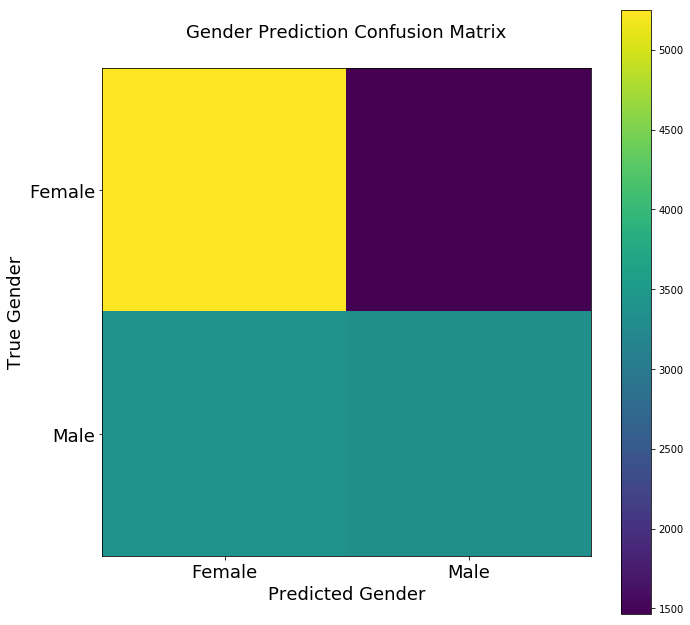

In [9]:
#First, we'll use the function we defined earlier to generate a the components of a confusion matrix
#for the gender predictions contained in the DataFrame.
cm = get_confusion_matrix(df)

#Next, we'll plot the confusion matrix
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xticklabels([''] + ["Female","Male"], fontsize=18)
ax.set_yticklabels([''] + ["Female","Male"], fontsize=18)
ax.xaxis.set_ticks_position("bottom")
plt.title("Gender Prediction Confusion Matrix", fontsize=18)
plt.xlabel('Predicted Gender', fontsize=18)
plt.ylabel('True Gender', fontsize=18)
plt.tight_layout()
fig.colorbar(cax)
plt.show()

In [10]:
'''
The above confusion matrix tells me that this classifier has very good recall, meaning it is able to identify
a high percentage of female customers correctly. Unfortunately, it doesn't seem to do a good job at a number
of other things. For example, it actually does worse than a coin flip at classifying a male customer correctly.
Lastly, for any given prediction the classifier makes, it has a ~2/3rds chance of being correct. All this tells me
that the classifier is predicting customers to be female much too often. I would try to think of creative ways to
find new features, or consider using another model to build the classifier.
'''